# Data Collection and Visualization

## 1 Preparation

In [ ]:
%matplotlib inline 

import os
import re
import random
import copy
from glob import glob
from pathlib import Path
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import scipy.io
import imageio
import cv2
from PIL import Image
import utils.constants as C

In [ ]:
dir1 = './data/raw/RTA'
dir2 = './data/raw/DME'
dir3 = './data/raw/AMD'
dir4 = './data/raw/AROI'
# dir5 = './data/dataverse_files'

seed = 6
random.seed(seed)

## 2 Data Analysis

### 2.1 OCTRIMA 3D (RTA)

* [This Data](http://www.plosone.org/article/fetchSingleRepresentation.action?uri=info:doi/10.1371/journal.pone.0133908.s002) is from ['Real-Time Automatic Segmentation of Optical Coherence Tomography Volume Data of the Macular Region'](https://www.researchgate.net/publication/280944318_Real-Time_Automatic_Segmentation_of_Optical_Coherence_Tomography_Volume_Data_of_the_Macular_Region) by Delia Cabrera Debuc

Layers and corresponding meanings are as follows:
![RTA](https://www.researchgate.net/profile/Delia-Debuc/publication/280944318/figure/fig16/AS:343687918833664@1458952993092/Exemplary-OCT-B-scan-from-Spectralis-SD-OCT-showing-eight-intraretinal-layer-boundaries.png)

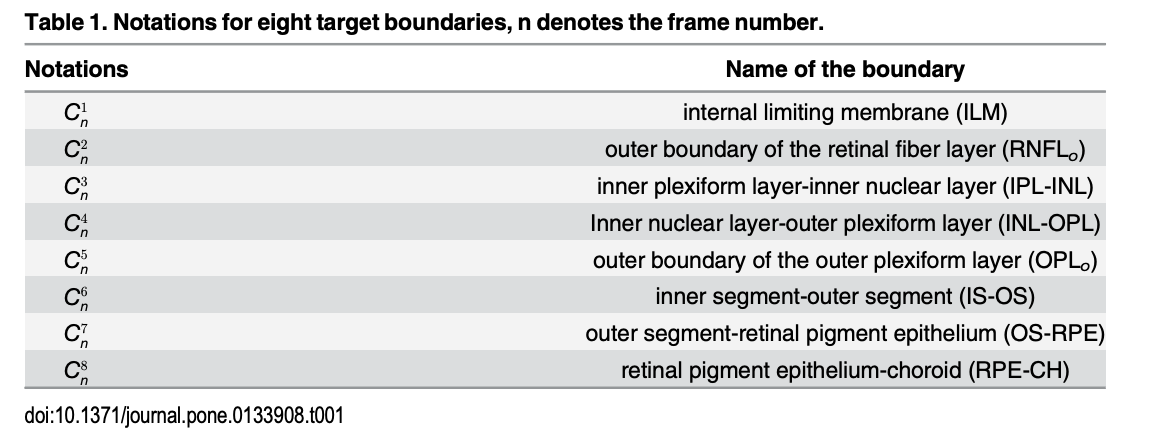

In [ ]:
num_file = 0
num_file_fluid = 0
idx_ini = 1
idx_end = 10

idx_test = random.randint(idx_ini, idx_end)
print('File Subject', idx_test, end='\n\n')

data1 = scipy.io.loadmat('{}/Subject{}.mat'.format(dir1, idx_test))
print(data1.keys())
print('header: ', data1['__header__'])
print('version: ', data1['__version__'])
print('global: ', data1['__globals__'], end='\n\n')

print('Label format (width, slice, layer)')
print('Shape of OCTRIMA3D: ', np.asarray(data1['OCTRIMA3D']).shape)
print('Shape of Observer1: ', np.asarray(data1['Observer1']).shape)
print('Shape of Observer2: ', np.asarray(data1['Observer2']).shape)
print('Shape of volumedata: ', np.asarray(data1['volumedata']).shape)

print(f"\n#Total files: {len(glob(dir1 + '/*.mat'))}, each with slice: {data1['volumedata'].shape[2]}")

In [ ]:
# Visualisation of a image and its 8 manually labeled layers

idx_img = random.randint(0,9)

volumeData = np.transpose(np.asarray(data1['volumedata']), (2,0,1))
Observer1 = np.transpose(np.asarray(data1['Observer1']), (1,2,0))
Observer2 = np.transpose(np.asarray(data1['Observer2']), (1,2,0))
OCTRIMA3D = np.transpose(np.asarray(data1['OCTRIMA3D']), (1,2,0))

fig, axes = plt.subplots(2,2, figsize=(6,6))
x = range(volumeData.shape[2])

axes[0,0].imshow(volumeData[idx_img])
axes[0,0].title.set_text('raw image')
axes[0,1].imshow(volumeData[idx_img])
for i in range(8):
  axes[0,1].plot(x, OCTRIMA3D[idx_img][i], color='r')
axes[0,1].title.set_text('OCTRIMA3D')
axes[1,0].imshow(volumeData[idx_img])
for i in range(8):
  axes[1,0].plot(x, Observer1[idx_img][i])
axes[1,0].title.set_text('Observer1')
axes[1,1].imshow(volumeData[idx_img])
for i in range(8):
  axes[1,1].plot(x, Observer2[idx_img][i])
axes[1,1].title.set_text('Observer2')

plt.tight_layout()

In [ ]:
for i in range(idx_ini, idx_end+1):
  tmp = scipy.io.loadmat('{}/Subject{}.mat'.format(dir1, i))
  tmp_num = np.asarray(tmp['volumedata'].shape[2])
  print('Number of labeled images in Subject{}.mat: {}'.format(i, tmp_num))
  num_file += tmp_num

print('Total Number of labeled images: ', num_file)

### 2.2 DME OCT Data with Manual Fluids & Labeled Layers

Dataset origin: Segmentation of OCT images (DME), Chiu 2015 [[kaggle](https://www.kaggle.com/paultimothymooney/chiu-2015)] [[homepage@duke](https://people.duke.edu/~sf59/Chiu_BOE_2014_dataset.htm)] [[paper](https://opg.optica.org/boe/fulltext.cfm?uri=boe-6-4-1172&id=312754#)]

![DME Layers](https://opg.optica.org/getImage.cfm?img=M3cuZnVsbCxib2UtNi00LTExNzItZzAwMw&article=boe-6-4-1172-g003)

In [ ]:
num_file = 0
num_file_fluid = 0
fluids = []
idx_ini = 1
idx_end = 10
# idx_test = random.randint(idx_ini, idx_end)
idx_test = 2

print('File Subject', idx_test, end='\n\n')

data2 =  scipy.io.loadmat('{}/Subject_{:02d}.mat'.format(dir2, idx_test))
print(data2.keys())
print('header: ', data2['__header__'])
print('version: ', data2['__version__'])
print('globals: ', data2['__globals__'], end='\n\n')

print('Shape of images: ', np.asarray(data2['images']).shape)
print('Shape of automaticFluidDME: ', np.asarray(data2['automaticFluidDME']).shape)
print('Shape of manualFluid1: ', np.asarray(data2['manualFluid1']).shape)
print('Shape of manualFluid2: ', np.asarray(data2['manualFluid2']).shape)
print('Shape of automaticLayersDME: ', np.asarray(data2['automaticLayersDME']).shape)
print('Shape of automaticLayersNormal: ', np.asarray(data2['automaticLayersNormal']).shape)
print('Shape of manualLayers1: ', np.asarray(data2['manualLayers1']).shape)
print('Shape of manualLayers2: ', np.asarray(data2['manualLayers2']).shape)

print(f"\n#Total images: {len(glob(dir2+'/*.mat'))}; each with slice {data2['images'].shape[2]}, {7} of them are labeled")

In [ ]:
# check which images have been labeled with fluids

manuFluid1 = np.asarray(data2['manualFluid1'])
print('Labeled Fluids: ')
for i in range(61):
  x = np.max(np.asarray(np.nan_to_num(manuFluid1[:,:,i])))
  if x > 0:
    print('Index: {}; Max Label: {}'.format(i, x))

def get_dme_valid_idx(patient):
    valid_idx = []
    for i in range(patient.shape[-1]):
        x = np.max(np.asarray(np.nan_to_num(manuFluid1[:,:,i])))
        if x > 0:
          valid_idx.append(i)
    return valid_idx

In [ ]:
# Visualisation of a image and its manually labeled fluids

idx_slice = 45

images = np.asarray(data2['images'])
autoFluid = np.asarray(data2['automaticFluidDME'])
manuFluid1 = np.asarray(data2['manualFluid1'])
manuFluid2 = np.asarray(data2['manualFluid2'])

fig, axes = plt.subplots(2,2, figsize=(6,6))

axes[0,0].imshow(images[:,:,idx_slice])
axes[0,0].title.set_text('raw image')
axes[0,1].imshow(np.nan_to_num(autoFluid[:,:,idx_slice]))
axes[0,1].title.set_text('automaticFluidDME')
axes[1,0].imshow(np.nan_to_num(manuFluid1[:,:,idx_slice]))
axes[1,0].title.set_text('manualFluid1')
axes[1,1].imshow(np.nan_to_num(manuFluid2[:,:,idx_slice]))
axes[1,1].title.set_text('manualFluid2')

plt.tight_layout()

In [ ]:
# Visualisation of a image and its 8 manually labeled layers

idx_slice = 45

images = np.asarray(data2['images'])
autoLayerDME = np.asarray(data2['automaticLayersDME'])
autoLayerNormal = np.asarray(data2['automaticLayersNormal'])
manuLayer1 = np.asarray(data2['manualLayers1'])
manuLayer2 = np.asarray(data2['manualLayers2'])

fig, axes = plt.subplots(3,2, figsize=(6,6))
x = range(autoLayerDME.shape[1])

axes[0,0].imshow(images[:,:,idx_slice])
axes[0,0].title.set_text('raw image')
axes[0,1].imshow(images[:,:,idx_slice])
axes[0,1].title.set_text('raw image')
axes[1,0].imshow(images[:,:,idx_slice])
axes[1,0].title.set_text('automaticLayersDME')
for i in range(4):
  axes[1,0].plot(x, autoLayerDME[i,:,idx_slice], color='r')
axes[1,1].imshow(images[:,:,idx_slice])
axes[1,1].title.set_text('automaticLayersNormal')
for i in range(8):
  axes[1,1].plot(x, autoLayerNormal[i,:,idx_slice])
axes[2,0].imshow(images[:,:,idx_slice])
axes[2,0].title.set_text('manualLayers1')
for i in range(8):
  axes[2,0].plot(x, manuLayer1[i,:,idx_slice])
axes[2,1].imshow(images[:,:,idx_slice])
axes[2,1].title.set_text('manualLayers2')
for i in range(8):
  axes[2,1].plot(x, manuLayer2[i,:,idx_slice])

plt.tight_layout()

In [ ]:
for j in range(idx_ini, idx_end+1):
  num_file += images.shape[2]
  for i in range(images.shape[2]):
    max_label = np.max(np.asarray(np.nan_to_num(manuFluid1[:,:,i])))
    if max_label > 0:
      num_file_fluid += 1
      fluids.append((j,i))

print("Number of Total Files: ", num_file)
print("Number of Files with Labeled Fluids: ", num_file_fluid)
print('Indexes of Fluids: ', fluids)

### 2.3 AMD OCT Data with Manual Fluids & Labeled Layers

This dataset is originally for segmentation of OCT images with ADM disease. It contains 38400 B-scans from 269 AMD patients and 115 normal subjects.

AMD Dataset can be downloaded with `kaggle` cml tool:

```bash
%bash
pip install kaggle
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
cd data
kaggle datasets download paultimothymooney/farsiu-2014
unzip farsiu-2014.zip
```

Dataset origin: Segmentation of OCT images (AMD), Farsiu 2013 [[kaggle](https://www.kaggle.com/paultimothymooney/farsiu-2014/home)] [[homepage@duke](https://people.duke.edu/~sf59/RPEDC_Ophth_2013_dataset.htm)] [[paper](http://people.duke.edu/~sf59/Farsiu_Ophthalmology_2013.pdf)]

In [ ]:
# AMD folder is for AMD patients
AMD2 = glob(os.path.join(dir3, 'AMD 2/AMD 2/*.mat'))
amd2 = glob(os.path.join(dir3, 'amd 2/AMD 2/*.mat'))
# Control folder is for normal people
control2 = glob(os.path.join(dir3, 'control 2/Control 2/*.mat'))
Control2 = glob(os.path.join(dir3, 'Control 2/Control 2/*.mat'))
print(f"Length of AMD2: {len(AMD2)}")
print(f"Length of amd2: {len(amd2)}")
print(f"Length of control2: {len(control2)}")
print(f"Length of Control2: {len(Control2)}")

In [ ]:
num_file = 0
num_file_fluid = 0
fluids = []
idx_ini = 1
idx_end = 10
# idx_test = random.randint(idx_ini, idx_end)
idx_test = 2

print('File Subject', idx_test, ':', AMD2[idx_test], end='\n\n')

data3 =  scipy.io.loadmat(amd2[idx_test])

print(data3.keys())
print('header: ', data3['__header__'])
print('version: ', data3['__version__'])
print('globals: ', data3['__globals__'], end='\n\n')

print('Format of images: (height, width, #slice)')
print('Shape of images: ', np.asarray(data3['images']).shape)
print(f"Format of layerMaps: (#slice, width, #layers)")
print('Shape of layerMaps: ', np.asarray(data3['layerMaps']).shape)
print('Shape of Age: ', np.asarray(data3['Age']).shape)

print(f"\n#Total files: {len(AMD2)}; each with slice {np.asarray(data3['images']).shape[2]}, {78} of them are labeled")

In [ ]:
images = data3['images']
layerMaps = data3['layerMaps']
age = data3['Age']

def get_valid_idx(layer_maps):
    '''
    The 11 B-scans per patient were annotated centered at fovea and 5 frames on either side of the fovea
    This function gives the valid B-scans index
    '''
    idx = []
    for i in range(layer_maps.shape[0]):
        temp = layer_maps[i,:,:]
        if np.sum(np.nan_to_num(temp)) != 0:
            idx.append(i)
    return idx

print(f"Valid slices of subject{idx_test}: {get_valid_idx(layerMaps)}")

Each layer map sepeartes the image by three lines. According to the [paper](https://people.duke.edu/~sf59/Farsiu_Ophthalmology_2013.pdf), these lines are called ***ILM***, ***Inner PREDC*** and ***Outer Bruch's Membrane*** from top to bottom.

In [ ]:
# Visualisation of a image and its manually labeled fluids

idx_img = 53

images = data3['images']
layerMaps = data3['layerMaps']
age = data3['Age']

fig, axes = plt.subplots(1,2, figsize=(12, 6))
x = range(layerMaps.shape[1])

axes[0].imshow(images[:,:,idx_img])
axes[0].title.set_text('raw image')
axes[1].imshow(images[:,:,idx_img])
for i in range(3): # 3
  axes[1].plot(x, layerMaps[idx_img,:,i], 'm')
# axes[1].imshow(np.nan_to_num(layerMaps[idx_img, :,:]))
axes[1].title.set_text('layerMaps')

plt.tight_layout()

### 2.4 AROI Data

This dataset is from [Annotated Retinal OCT Images database - AROI database](https://ipg.fer.hr/ipg/resources/oct_image_database)

This is a picture from original paper: the layers form top to bottom are called *internal limiting membrane* (**ILM**), *boundaries between the inner plexiform layer and inner nuclear layer* (**IPL/INL**), *retinal pigment epithelium* (**RPE**), and *Bruch membrane* (**BM**)

![image](https://ipg.fer.hr/images/50037599/nasa%20baza.png)

In [ ]:
patient_idx = 19
image_idx = 59
raw_path = f"24 patient/patient{patient_idx}/raw/labeled/patient{patient_idx}_raw{image_idx:04d}.png"
color_path = f"24 patient/patient{patient_idx}/mask/number/patient{patient_idx}_raw{image_idx:04d}.png"
raw_img = imageio.imread(os.path.join(dir4, raw_path))
color_img = imageio.imread(os.path.join(dir4, mask_path))
arr_img = np.asarray(color_img)
print(arr_img)
print(arr_img)
print(arr_img.shape)
col = arr_img[:, 350]
uni = np.unique(col)
uni_idx = np.unique(col, return_index=True)[1]
print([col[idx] for idx in sorted(uni_idx)])
print(np.max(col))
print(np.max(np.asarray(color_img)))

print(f"\n#Total files: {len(glob(dir4 + '/24 patient/patient*/raw/labeled/*.png'))}; it is composed of {len(glob(dir4+'/24 patient/patient*'))} patients, each patient has {len(glob(dir4+'/24 patient/patient1/mask/number/*.png'))} slice images")

In [ ]:
def detect_edges(img):
    '''
    Detect edges vertically. It returns edges in the shape of (width, #edges)
    '''
    shape = img.shape
    num_edge = 4
    edges = np.zeros((shape[1], num_edge), dtype=int)
    for i in range(shape[1]):
        for j in range(1, num_edge+1):
        # get the upper bound of class j
        idx = np.nonzero(img[:, i] == j)[0][0]
        # if fluids on boundary, get the lower bound of class j-1
        if idx - edges[i-1][j-1] > 15:
            idx = np.nonzero(img[:, i] == j-1)[0][-1]
        edges[i][j-1] = idx
    return edges

In [ ]:
def detect_fluids(img, intensities):
    '''
    Detect fluids. It returns edges in the shape of img
    '''
    labels = [5, 6, 7]
    fluids = np.zeros_like(img)
    for idx, label in enumerate(labels):
        coor_tuples = np.where(img == label)
        if coor_tuples[0].size != 0:
            intensity = intensities[idx]
            coors = zip(coor_tuples[0], coor_tuples[1])
            for coor in coors:
                fluids[coor[0]][coor[1]] = intensity
    return fluids

In [ ]:
edges = detect_edge(color_img)
fluids = detect_fluids(color_img, [50, 150, 250])

print(edges.shape)
fig, axes = plt.subplots(1, 4, figsize=(12, 12))
axes[0].imshow(raw_img)
axes[1].imshow(color_img)
axes[2].imshow(raw_img)
for i in range(4):
    axes[2].plot(range(512), edges[:, i], color = 'r')
axes[3].imshow(fluids)

### 2.5 Dataverse File Analysis [Deprecated]

dataverse_files

In [ ]:
mat = scipy.io.loadmat(dir5+'/9 macula - Copy.jpeg_octSegmentation.mat')
type(mat)

In [ ]:
print(mat.keys())
print(mat['imageLayer'].shape)
print(type(mat['imageLayer'][0,1]))
print(mat['imageLayer'][0,1][0])
print(type(mat['imageLayer'][0,1][1]))
print(mat['imageLayer'][0,1][1].shape)

## 3 Create Dataset

Datasets will be created following this [guide](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/datasets.md#pix2pix-datasets).


### 3.0 Define unified boundaries
First we define different value for each layer:

![DME Layers](https://opg.optica.org/getImage.cfm?img=M3cuZnVsbCxib2UtNi00LTExNzItZzAwMw&article=boe-6-4-1172-g003)

-----

![RTA Layers Image](https://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0133908.g001) | ![RTA Layers Explanation](https://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0133908.t001)
-- | --

![AMD Layers](https://www.ncbi.nlm.nih.gov/pmc/articles/instance/3901571/bin/nihms-508161-f0001.jpg)

----

![AROI Layers](https://ipg.fer.hr/images/50037599/nasa%20baza.png)

In [ ]:
num_gap = 12 + 1
gap = 255 // num_gap

ILM = 1 * gap # present in 1, 2, 3, 4
RNFL_o = 2 * gap # NFL/FCL in DME, present in 2
IPL_INL = 3 * gap
INL_OPL = 4 * gap
OPL_o = 5 * gap # OPL/ONL in DME
ISM_ISE = 6 * gap
IS_OS = 7 * gap
OS_RPE = 8 * gap

# not sure whether they are the same
RPE = 9 * gap
# RPEDC = 10 * gap
# RPE = 11 * gap

BM = 10 * gap

print(0, ILM, RNFL_o, IPL_INL, INL_OPL, OPL_o, ISM_ISE, IS_OS, OS_RPE, RPE, BM, 255)

In [ ]:
RTA_labels = [ILM, RNFL_o, IPL_INL, INL_OPL, OPL_o, IS_OS, OS_RPE, RPE]
DME_labels = [ILM, RNFL_o, IPL_INL, INL_OPL, OPL_o, ISM_ISE, OS_RPE, BM]
AMD_labels = [ILM, RPE, BM]
AROI_labels = [ILM, IPL_INL, RPE, BM]

### Define convert script

In [ ]:
def convert_to_dataset(file_pattern, bscan_key, layermap_key, bscan_format, layermap_format, layer_labels, bscan_folder, layer_folder, 
                       valid_slice_indices_fn=None, remove_from=None, n_remove=0, overwrite=True):
    '''
    Convert bscan and layermap pairs to datasets. Bscans and corresponding layer images will be extracted from given mat files, and
    will be saved as .jpg images to specified bscan and layer folders with the original file name.
    If remove_from is specified, n_remove layers randomly sampled from remove_from list will be removed.
    Args:
      file_pattern (str): a pattern leads to mat files, which contains bscans and layermaps, i.e. /path/to/mat/patient*.mat
      bscan_key (str): the retrieval key of the bscan in the mat
      layermap_key (str): the retrieval key of the layermap in the mat
      bscan_format (str): a combination of h(height), w(width), s(slice); their location corresponds to the shape of bscan file, i.e. 'hws'
      layermap_format (str): a combination of w, s, l(layer)
      layer_labels (list(int)): the values to assigned to each layer
      bscan_folder (str): the folder to save bscan slice images
      layer_folder (str): the folder to save layer slice images
      valid_slice_indices_fn (function): a function to find valid slice indices in a mat
      remove_from (list(int)): a list of layers that can be removed
      n_remove (int): number of layers to remove. It should be smaller than the length of remove_from list
      overwrite (bool): overwrite existed files.
    '''
    for f in tqdm(glob(file_pattern)):
        mat = scipy.io.loadmat(f)
        bscan = np.asarray(mat[bscan_key])
        layermap = np.asarray(np.nan_to_num(mat[layermap_key]), dtype=int)
        assert len(bscan.shape) == 3 and len(bscan_format) == 3, f"bscan is expected to be three dim, but get {bscan_format}({len(bscan.shape)})"
        height = bscan.shape[bscan_format.index('h')]
        width = bscan.shape[bscan_format.index('w')]
        n_slice = bscan.shape[bscan_format.index('s')]
        n_layer = layermap.shape[layermap_format.index('l')]
        assert len(layer_labels) >= n_layer, f"layer_labels should have more elements that #layers({n_layer}), but got length {len(layer_labels)}"
        assert 'w' in layermap_format and 's' in layermap_format and 'l' in layermap_format, f"layermap_format is illegal, got {layermap_format}"
        assert layermap.shape[layermap_format.index('w')] == width, f"width of bscan ({width}) is inconsistent with that of layermap ({layermap.shape[layermap_format.index('w')]})"
        assert layermap.shape[layermap_format.index('s')] == n_slice, f"#slice of bscan ({n_slice}) is inconsistent with that of layermap ({layermap.shape[layermap_format.index('s')]})"
        if valid_slice_indices_fn is not None:
            valid_slice_indices = valid_slice_indices_fn(mat)
        else:
            valid_slice_indices = range(n_slice)
        for s in valid_slice_indices:
            # check existence, this only works when remove_from is None
            save_name = f.split('/')[-1].split('.')[0] + '_' + str(s) + '.jpg'
            if not overwrite and Path(os.path.join(bscan_folder, save_name)).exists() and Path(os.path.join(layer_folder, save_name)).exists():
                continue
            if bscan_format.index('s') == 0:
                scan_slice = bscan[s, :, :]
            elif bscan_format.index('s') == 1:
                scan_slice = bscan[:, s, :]
            else: # bscan_format.index('s') == 2
                scan_slice = bscan[:, :, s]
            layer_slice = np.zeros_like(scan_slice)
            # sample layers to remove if remove_from is specified
            layers_remove = None
            if remove_from is not None:
                layers_remove = random.sample(remove_from, n_remove)
                layers_remove = sorted(layers_remove)
            for l in range(n_layer):
                # skip removed layers
                if remove_from is not None and l in layers_remove:
                    continue
                layer_map_width_indice = [0,0,0]
                layer_map_width_indice[layermap_format.index('s')] = s
                layer_map_width_indice[layermap_format.index('l')] = l
                layer_map_width_indice[layermap_format.index('w')] = range(width)
                layer_map_width_indice = tuple(layer_map_width_indice)
                layer_slice[layermap[layer_map_width_indice], range(width)] = layer_labels[l] # substitute with layer-specific constant
            # This restores the zero-th line of each image back to black pixels (it assumes they used to be black pixels)
            # P.S. I forgot why I need this line
            layer_slice[0, :] = 0
            # Save each slice as a file
            scan_slice_img = Image.fromarray(scan_slice)
            layer_slice_img = Image.fromarray(layer_slice)
            save_name = f.split('/')[-1].split('.')[0] + '_' + str(s) + '.jpg'
            if remove_from is not None and len(layers_remove) > 0:
                save_name = save_name.split('.')[0] + '_del' + ''.join(str(x) for x in layers_remove) + '.jpg'
            scan_slice_img.save(os.path.join(bscan_folder, save_name))
            layer_slice_img.save(os.path.join(layer_folder, save_name))

### 3.1 Create datasets for RTA [*Real-Time Automatic Segmentation of Optical Coherence Tomography Volume Data of the Macular Region*](https://www.researchgate.net/publication/280944318_Real-Time_Automatic_Segmentation_of_Optical_Coherence_Tomography_Volume_Data_of_the_Macular_Region).

We name the folder for this dataset as RTA

In [ ]:
rta_bscan_folder = './data/datasets/RTA/bscans'
rta_layer_folder = './data/datasets/RTA/layers'
!mkdir -p $rta_bscan_folder $rta_layer_folder

The original verified (data specific) code:
```python
for f in glob(dir1 + '/*.mat'):
    mat = scipy.io.loadmat(f)
    bscan = np.asarray(mat['volumedata']) # height, width, slice
    layermap = np.asarray(mat['Observer2'], dtype=int) # width, slice, layer
    height, width, n_slice = bscan.shape
    n_layer = layermap.shape[2]
    # TODO: find out the practical meaning of different layers
    for s in range(n_slice):
        scan_slice = bscan[:, :, s]
        layer_slice = np.zeros_like(scan_slice)
        for l in range(n_layer):
            layer_slice[layermap[:, s, l], range(width)] = RTA_labels[l] # substitute with layer-specific constant
        # Save each slice as a file
        scan_slice_img = Image.fromarray(scan_slice)
        layer_slice_img = Image.fromarray(layer_slice)
        save_name = f.split('/')[-1].split('.')[0] + '_' + str(s) + '.jpg'
        scan_slice_img.save(os.path.join(rta_bscan_folder, save_name))
        layer_slice_img.save(os.path.join(rta_layer_folder, save_name))
```

In [ ]:
# RTA Call
convert_to_dataset(file_pattern=dir1 + '/*.mat', 
                   bscan_key='volumedata', 
                   layermap_key='Observer2',
                   bscan_format='hws',
                   layermap_format='wsl',
                   layer_labels=RTA_labels,
                   bscan_folder=rta_bscan_folder,
                   layer_folder=rta_layer_folder,
                   overwrite=False)

### 3.2 Create dataset for DME

In [ ]:
dme_bscan_folder = './data/datasets/DME/bscans'
dme_layer_folder = './data/datasets/DME/layers'
!mkdir -p $dme_bscan_folder $dme_layer_folder

In the DME dataset, for each layer, it is not a complete layer stretch from leftmost to rightmost, some layers even come with uncontinous lines.

The original validated implementation:
```python
for f in glob(dir2 + '/*.mat'):
    mat = scipy.io.loadmat(f)
    bscan = np.asarray(mat['images']) # height, width, slice
    # nan_to_num moves uncontinous layer segments to zero-th line
    layermap = np.asarray(np.nan_to_num(mat['manualLayers1']), dtype=int) # layer, width, slice
    height, width, n_slice = bscan.shape
    n_layer, width, n_slice = layermap.shape
    # TODO: find out the practical meaning of different layers
    for s in get_dme_valid_idx(mat):
        scan_slice = bscan[:, :, s]
        layer_slice = np.zeros_like(scan_slice)
        for l in range(n_layer):
            layer_slice[layermap[l, :, s], range(width)] = DME_labels[l] # substitute with layer-specific constant
        # This restores the zero-th line of each image back to black pixels (it assumes they used to be black pixels)
        layer_slice[0, :] = 0
        # Save each slice as a file
        scan_slice_img = Image.fromarray(scan_slice)
        layer_slice_img = Image.fromarray(layer_slice)
        save_name = f.split('/')[-1].split('.')[0] + '_' + str(s) + '.jpg'
        scan_slice_img.save(os.path.join(dme_bscan_folder, save_name))
        layer_slice_img.save(os.path.join(dme_layer_folder, save_name))
```

In [ ]:
def get_dme_valid_idx(patient, key='manualLayers1'):
    valid_idx = []
    for i in range(patient[key].shape[-1]):
        x = np.max(np.asarray(np.nan_to_num(patient[key][:,:,i])))
        if x > 0:
          valid_idx.append(i)
    return valid_idx

In [ ]:
# DME Call
convert_to_dataset(file_pattern=dir2+'/*.mat',
                   bscan_key='images',
                   layermap_key='manualLayers1',
                   bscan_format='hws',
                   layermap_format='lws',
                   layer_labels=DME_labels,
                   bscan_folder=dme_bscan_folder,
                   layer_folder=dme_layer_folder,
                   valid_slice_indices_fn=get_dme_valid_idx)

### 3.3 Create datasets for AMD

```
Format of images: (height, width, #slice)
Shape of images:  (512, 1000, 100)
Format of layerMaps: (#slice, width, #layers)
Shape of layerMaps:  (100, 1000, 3)
```

The original validated method:
```python
# TODO: add both AMD and control group
for f in tqdm(glob(dir3 + '/Control 2/Control 2/*.mat')):  # + glob(/AMD 2/AMD 2/*.mat)
    mat = scipy.io.loadmat(f)
    bscan = np.asarray(mat['images']) # height, width, slice
    # nan_to_num moves uncontinous layer segments to zero-th line
    layermap = np.asarray(np.nan_to_num(mat['layerMaps']), dtype=int) # slice, width, layer
    height, width, n_slice = bscan.shape
    n_slice, width, n_layer = layermap.shape
    # TODO: find out the practical meaning of different layers
    for s in get_amd_valid_idx(mat):
        scan_slice = bscan[:, :, s]
        layer_slice = np.zeros_like(scan_slice)
        for l in range(n_layer):
            layer_slice[layermap[s, :, l], range(width)] = AMD_labels[l] # substitute with layer-specific constant
        # This restores the zero-th line of each image back to black pixels (it assumes they used to be black pixels)
        layer_slice[0, :] = 0
        # Save each slice as a file
        scan_slice_img = Image.fromarray(scan_slice)
        layer_slice_img = Image.fromarray(layer_slice)
        save_name = f.split('/')[-1].split('.')[0] + '_' + str(s) + '.jpg'
        scan_slice_img.save(os.path.join(amd_bscan_folder, save_name))
        layer_slice_img.save(os.path.join(amd_layer_folder, save_name))
```

In [ ]:
amd_bscan_folder = './data/datasets/AMD/bscans'
amd_layer_folder = './data/datasets/AMD/layers'
!mkdir -p $amd_bscan_folder $amd_layer_folder

In [ ]:
def get_amd_valid_idx(patient, key='layerMaps'):
    '''
    The 11 B-scans per patient were annotated centered at fovea and 5 frames on either side of the fovea
    This function gives the valid B-scans index
    '''
    idx = []
    for i in range(patient[key].shape[0]):
        x = patient[key][i,:,:]
        if np.sum(np.nan_to_num(x)) != 0:
            idx.append(i)
    return idx

In [ ]:
# Control data
convert_to_dataset(file_pattern=dir3+'/Control 2/Control 2/*.mat', 
                   bscan_key='images',
                   layermap_key='layerMaps',
                   bscan_format='hws',
                   layermap_format='swl',
                   layer_labels=AMD_labels,
                   bscan_folder=amd_bscan_folder,
                   layer_folder=amd_layer_folder,
                   valid_slice_indices_fn=get_amd_valid_idx,
                   overwrite=False)

In [ ]:
!ls './data/AMD/AMD 2/AMD 2'

In [ ]:
convert_to_dataset(file_pattern=dir3+'/AMD 2/AMD 2/Farsiu_Ophthalmology_2013_AMD_Subject_10*.mat', 
                   bscan_key='images',
                   layermap_key='layerMaps',
                   bscan_format='hws',
                   layermap_format='swl',
                   layer_labels=AMD_labels,
                   bscan_folder=amd_bscan_folder,
                   layer_folder=amd_layer_folder,
                   valid_slice_indices_fn=get_amd_valid_idx,
                   overwrite=False)

### 3.4 Create dataset for AROI

In [ ]:
aroi_bscan_folder = './data/datasets/AROI/bscans'
aroi_layer_folder = './data/datasets/AROI/layers'
aroi_error_folder = './data/datasets/AROI/error'
!mkdir -p $aroi_bscan_folder $aroi_layer_folder $aroi_error_folder

In [ ]:
raw_path = f"24 patient/patient*/raw/labeled/*.png"
mask_path = f"24 patient/patient*/mask/number/*.png"
mask_trunk = "24 patient/patient{patient_number}/mask/number/patient{patient_number}_raw{slice_number}.png"
name_pattern = re.compile("patient([0-9]+)_raw([0-9]+)\.png")
raw_list = glob(os.path.join(dir4, raw_path))
mask_list = glob(os.path.join(dir4, mask_path))
raw_files = [i.split('/')[-1] for i in raw_list]
mask_files = [i.split('/')[-1] for i in mask_list]

In [ ]:
len(raw_list)

In [ ]:
for f in os.listdir(aroi_bscan_folder):
  os.remove(os.path.join(aroi_bscan_folder, f))
for f in os.listdir(aroi_layer_folder):
  os.remove(os.path.join(aroi_layer_folder, f))
for f in os.listdir(aroi_error_folder):
  os.remove(os.path.join(aroi_error_folder, f))

In [ ]:
def detect_edge(img):
    '''
    Detect edges vertically. It return edges in shape (width, #edges)
    '''
    shape = img.shape
    num_edge = 4
    edges = np.zeros((shape[1], num_edge), dtype=int)
    for i in range(shape[1]):
      for j in range(1, num_edge+1):
        # get the upper bound of class j
        idx = np.nonzero(img[:, i] == j)[0][0]
        # if fluids on boundary, get the lower bound of class j-1
        if idx - edges[i-1][j-1] > 15:
          idx = np.nonzero(img[:, i] == j-1)[0][-1]
        edges[i][j-1] = idx
    return edges

# raw_list = ['./data/AROI/24 patient/patient9/raw/labeled/patient9_raw0036.png']

# The file order is system-dependent, on linux they corresponds well
skipped_files = 0
for raw in tqdm(raw_list):
    assert raw.split('/')[-1] in mask_files, f"raw image {raw} does not correspond to any image in mask files"
    patient_idx, slice_idx = name_pattern.fullmatch(raw.split('/')[-1]).groups(0)
    mask = mask_trunk.format(patient_number=patient_idx, slice_number=slice_idx)
    mask = os.path.join(dir4, mask)
    try:
        raw_img = imageio.imread(raw) # height, width
    except Exception as e:
        print(f"[{skipped_files}]Error occurred when opening {raw}")
        print(e)
        skipped_files += 1
        continue
    mask_img = None
    try:
        mask_img = imageio.imread(mask)
    except Exception as e:
        print(f"Error occurred when reading mask", mask)
    if mask_img is None:
        print(f"[{skipped_files}]Read mask is none")
        skipped_files += 1
        continue
    try:
        edges = detect_edge(mask_img) # width, #layers
    except Exception as e:
        print(f"Error occurred when processing", mask)
        print(e)
        continue
        # raise e
    width, n_layer = edges.shape
    # TODO: find out the practical meaning of different layers
    layer_slice = np.zeros_like(raw_img)
    for l in range(n_layer):
        layer_slice[edges[:, l], range(width)] = AROI_labels[l] # substitute with layer-specific constant
    # Save each slice as a file
    scan_slice_img = Image.fromarray(raw_img)
    layer_slice_img = Image.fromarray(layer_slice)
    save_name = raw.split('/')[-1].split('.')[0] + '.jpg'
    scan_slice_img.save(os.path.join(aroi_bscan_folder, save_name))
    layer_slice_img.save(os.path.join(aroi_layer_folder, save_name))

In [ ]:
!ls ./data/AROI/24 patient/patient1/raw/labeled/patient1_raw0037.png

In [ ]:
for raw in raw_list:
    save_name = raw.split('/')[-1].split('.')[0] + '.jpg'
    Path(os.path.join(aroi_bscan_folder, save_name)).touch()
    Path(os.path.join(aroi_layer_folder, save_name)).touch()

In [ ]:
# raw = 'data/AROI/24 patient/patient9/raw/labled/patient9_raw0036.png'
mask = './data/AROI/24 patient/patient9/mask/number/patient9_raw0034.png'
mask_img = imageio.imread(mask)
# raw_img = imageio.imread(raw)
edges = detect_edge(mask_img)

In [ ]:
!ls './data/AROI/24 patient/patient19/raw/labeled/patient19_raw0074.png'

## 5. Randomly remove layers to form new training sample 

### 5.1 Created reduced RTA

In [ ]:
rta_bscan_reduced_folder = './data/reduced/RTA/bscans'
rta_layer_reduced_folder = './data/reduced/RTA/layers'
!mkdir -p $rta_bscan_reduced_folder $rta_layer_reduced_folder

In [ ]:
convert_to_dataset(file_pattern=dir1 + '/Subject[78]*.mat', 
                   bscan_key='volumedata', 
                   layermap_key='Observer2',
                   bscan_format='hws',
                   layermap_format='wsl',
                   layer_labels=RTA_labels,
                   bscan_folder=rta_bscan_reduced_folder,
                   layer_folder=rta_layer_reduced_folder,
                   remove_from=range(2,8), # 6 out of 8
                   n_remove=1)
convert_to_dataset(file_pattern=dir1 + '/Subject[56]*.mat', 
                   bscan_key='volumedata', 
                   layermap_key='Observer2',
                   bscan_format='hws',
                   layermap_format='wsl',
                   layer_labels=RTA_labels,
                   bscan_folder=rta_bscan_reduced_folder,
                   layer_folder=rta_layer_reduced_folder,
                   remove_from=range(2,8), # 6 out of 8
                   n_remove=2)
convert_to_dataset(file_pattern=dir1 + '/Subject[34]*.mat', 
                   bscan_key='volumedata', 
                   layermap_key='Observer2',
                   bscan_format='hws',
                   layermap_format='wsl',
                   layer_labels=RTA_labels,
                   bscan_folder=rta_bscan_reduced_folder,
                   layer_folder=rta_layer_reduced_folder,
                   remove_from=range(2,8), # 6 out of 8
                   n_remove=3)

### 4.2 Create reduced DME

In [ ]:
dme_bscan_reduced_folder = './data/reduced/DME/bscans'
dme_layer_reduced_folder = './data/reduced/DME/layers'
!mkdir -p $dme_bscan_reduced_folder $dme_layer_reduced_folder

In [ ]:
!ls $dir2

In [ ]:
convert_to_dataset(file_pattern=dir2+'/Subject_0[89].mat',
                   bscan_key='images',
                   layermap_key='manualLayers1',
                   bscan_format='hws',
                   layermap_format='lws',
                   layer_labels=DME_labels,
                   bscan_folder=dme_bscan_reduced_folder,
                   layer_folder=dme_layer_reduced_folder,
                   valid_slice_indices_fn=get_dme_valid_idx,
                   remove_from=range(2,8), # DME also has 8 layers, we choose 6 out of 8
                   n_remove=1)
convert_to_dataset(file_pattern=dir2+'/Subject_0[67].mat',
                   bscan_key='images',
                   layermap_key='manualLayers1',
                   bscan_format='hws',
                   layermap_format='lws',
                   layer_labels=DME_labels,
                   bscan_folder=dme_bscan_reduced_folder,
                   layer_folder=dme_layer_reduced_folder,
                   valid_slice_indices_fn=get_dme_valid_idx,
                   remove_from=range(2,8), # DME also has 8 layers, we choose 6 out of 8
                   n_remove=2)
convert_to_dataset(file_pattern=dir2+'/Subject_0[45].mat',
                   bscan_key='images',
                   layermap_key='manualLayers1',
                   bscan_format='hws',
                   layermap_format='lws',
                   layer_labels=DME_labels,
                   bscan_folder=dme_bscan_reduced_folder,
                   layer_folder=dme_layer_reduced_folder,
                   valid_slice_indices_fn=get_dme_valid_idx,
                   remove_from=range(2,8), # DME also has 8 layers, we choose 6 out of 8
                   n_remove=3)

### 4.3 Create reduced AMD

The AMD dataset only comes with 3 layers, we don't remove layers from it.

In [ ]:
amd_bscan_reduced_folder = './data/reduced/AMD/bscans'
amd_layer_reduced_folder = './data/reduced/AMD/layers'
!mkdir -p $amd_bscan_reduced_folder $amd_layer_reduced_folder

## 4. Split all datasets into train, val and test

In [ ]:
import random
import shutil
import pathlib


def split_files(bscans, ratio_train, ratio_test):
    '''Split files into train, val and test set. The ratio of val data will be 
    inducted from train and test ratio.
    Args:
      bscans (list): A list that contains all bscan files
      ratio_train (float): The ratio of train data
      ratio_test (float): The ratio of test data
    Return:
      Three lists of splited train, test and val files. Only file names will be
      preserved. The path will be discarded.
    '''
    if bscans is None or len(bscans) == 0:
        print("[Warn] input file list is empty")
    file_names = [f.split('/')[-1] for f in bscans]
    random.shuffle(file_names)
    split_train = int(len(file_names) * ratio_train)
    split_test = int(len(file_names) * ratio_test)
    train_files = file_names[:split_train]
    test_files = file_names[split_train:split_train+split_test]
    val_files = file_names[split_train+split_test:]
    return train_files, test_files, val_files

def move_files(splited_files, src_folder, dst_folder):
    '''Move files to destination folders according to file splits
    Args:
      splited_files (dict(list)): a dictionary that contains train, test, val files
      src_folder (str): i.e. 'data/datasets/RTA', there exists bscans & layers in it
      dst_folder (str): i.e. 'data/datasets/splited', there exists bscans and and
         layers folders in it. Under them, there exists train, val and test folders
    '''
    for mode in ['train', 'test', 'val']:
        for f in splited_files[mode]:
            # Move bscans
            bscans_dst_folder = os.path.join(dst_folder, 'bscans', mode)
            pathlib.Path(bscans_dst_folder).mkdir(parents=True, exist_ok=True)
            shutil.move(os.path.join(src_folder, 'bscans', f),
                        os.path.join(bscans_dst_folder, f))
            # Move layers
            layers_dst_folder = os.path.join(dst_folder, 'layers', mode)
            pathlib.Path(layers_dst_folder).mkdir(parents=True, exist_ok=True)
            shutil.move(os.path.join(src_folder, 'layers', f),
                        os.path.join(layers_dst_folder, f))

Available datasets:

In [ ]:
!ls ./data/datasets

In [ ]:
!ls ./data/datasets/RTA

In [ ]:
# !rm -rf ./data/datasets/RTA/bscans/val ./data/datasets/RTA/bscans/train ./data/datasets/RTA/bscans/test
# !rm -rf ./data/datasets/RTA/layers/val ./data/datasets/RTA/layers/train ./data/datasets/RTA/layers/test
# !rm -rf ./data/datasets/DME/bscans/val ./data/datasets/DME/bscans/train ./data/datasets/DME/bscans/test
# !rm -rf ./data/datasets/DME/layers/val ./data/datasets/DME/layers/train ./data/datasets/DME/layers/test

Shared parameters and functions:

In [ ]:
ratio_train = 0.8
ratio_test = 0.1
# ratio_val = 1 - ratio_train - ratio_test

### 4.1 for original datasets

We place it under `data/datasets/layer2bscan`

Split RTA:

In [ ]:
bscan_files = glob('./data/datasets/RTA/bscans/*.jpg')
train_files, test_files, val_files = split_files(bscan_files, 0.8, 0.1)
assert len(train_files) != 0, f"train_files is empty, data may have already been moved"

splited_files = {
    'train': train_files,
    'test': test_files,
    'val': val_files
}
move_files(splited_files, 'data/datasets/RTA', 'data/splits/RTA')

Split DME:

In [ ]:
bscan_files = glob('./data/datasets/DME/bscans/*.jpg')
train_files, test_files, val_files = split_files(bscan_files, 0.8, 0.1)
assert len(train_files) != 0, f"train_files is empty, data may have already been moved"

splited_files = {
    'train': train_files,
    'test': test_files,
    'val': val_files
}
move_files(splited_files, 'data/datasets/DME', 'data/splits/DME')

In [ ]:
!mv data/datasets/splited/layers/train/* data/datasets/RTA/layers/

Split AMD:

In [ ]:
bscan_files = glob('./data/datasets/AMD/bscans/*.jpg')
train_files, test_files, val_files = split_files(bscan_files, 0.8, 0.1)
assert len(train_files) != 0, f"train_files is empty, data may have already been moved"

splited_files = {
    'train': train_files,
    'test': test_files,
    'val': val_files
}
move_files(splited_files, 'data/datasets/AMD', 'data/splits/AMD')

Split AROI:

In [ ]:
bscan_files = glob('./data/datasets/AROI/bscans/*.jpg')
train_files, test_files, val_files = split_files(bscan_files, 0.8, 0.1)
assert len(train_files) != 0, f"train_files is empty, data may have already been moved"

splited_files = {
    'train': train_files,
    'test': test_files,
    'val': val_files
}
move_files(splited_files, 'data/datasets/AROI', 'data/splits/AROI')

### 4.2 for reduced datasets

We place it under `data/datasets/layer2bscan_reduced`

Split reduced RTA

In [ ]:
bscan_files = glob('./data/reduced/RTA/bscans/*.jpg')
train_files, test_files, val_files = split_files(bscan_files, 0.8, 0.1)
assert len(train_files) != 0, f"train_files is empty, data may have already been moved"

splited_files = {
    'train': train_files,
    'test': test_files,
    'val': val_files
}
move_files(splited_files, 'data/reduced/RTA', 'data/splits/reduced/RTA')

Split reduced DME

In [ ]:
bscan_files = glob('./data/reduced/DME/bscans/*.jpg')
train_files, test_files, val_files = split_files(bscan_files, 0.8, 0.1)
assert len(train_files) != 0, f"train_files is empty, data may have already been moved"

splited_files = {
    'train': train_files,
    'test': test_files,
    'val': val_files
}
move_files(splited_files, 'data/reduced/DME', 'data/splits/reduced/DME')

## 6. Create pix2pix dataset
using the script from [junyanz/pytorch-CycleGAN-and-pix2pix](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/datasets.md#pix2pix-datasets)

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [ ]:
!cd pytorch-CycleGAN-and-pix2pix && pip install -r requirements.txt

In [ ]:
!ls

### 6.1 Create pix2pix compatible datasets for original data

#### 6.1.1 RTA

In [ ]:
!python pytorch-CycleGAN-and-pix2pix/datasets/combine_A_and_B.py --fold_A data/splits/RTA/layers --fold_B data/splits/RTA/bscans --fold_AB data/datasets/layer2bscan

#### 6.1.2 DME

In [ ]:
!ls data/datasets/layer2bscan/test

In [ ]:
!python pytorch-CycleGAN-and-pix2pix/datasets/combine_A_and_B.py --fold_A data/splits/DME/layers --fold_B data/splits/DME/bscans --fold_AB data/datasets/layer2bscan

### 6.1.3 AMD

In [ ]:
!python pytorch-CycleGAN-and-pix2pix/datasets/combine_A_and_B.py --fold_A data/splits/AMD/layers --fold_B data/splits/AMD/bscans --fold_AB data/datasets/layer2bscan

### 6.1.4 AROI

In [ ]:
!python pytorch-CycleGAN-and-pix2pix/datasets/combine_A_and_B.py --fold_A data/splits/AROI/layers --fold_B data/splits/AROI/bscans --fold_AB data/datasets/layer2bscan

### 6.2 Create pix2pix-compatible datasets for reduced data

#### 6.2.1 RTA

In [ ]:
!ls data/datasets/layer2bscan_reduced/test

In [ ]:
!python pytorch-CycleGAN-and-pix2pix/datasets/combine_A_and_B.py --fold_A data/reduced/RTA/layers --fold_B data/reduced/RTA/bscans --fold_AB data/datasets/layer2bscan_reduced

#### 6.2.2 DME

In [ ]:
!python pytorch-CycleGAN-and-pix2pix/datasets/combine_A_and_B.py --fold_A data/reduced/DME/layers --fold_B data/reduced/DME/bscans --fold_AB data/datasets/layer2bscan_reduced

#### 6.2.4 AROI

In [ ]:
ls data/dataset